In [1]:
import symforce
symforce.set_epsilon_to_symbol()

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as R

import vo, vio
# pose_metrics requires evo (see top of pose_metrics.py for install instructions)
import pose_metrics
import utils

# Note: this notebook requires pandas in addition to all of Prof. Bretl's dependencies
import pandas as pd

### Provide settings

In [2]:
# When matching (max threshold for ratio test)
matching_threshold = 0.1 # I recommend 0.1 for KITTI and 0.5 for EuRoC

# When deciding if triangulated points are invalid
max_reprojection_err = 0.75

# Temporary folder for evo metrics
temporary_folder = Path('./temp')
temporary_folder.mkdir(parents=True, exist_ok=True)

### Read data

In [3]:
# RUN THIS CELL FOR KITTI
kitti_base_path = '/home/jlee/Downloads'
kitti_date = '2011_09_26'
kitti_drive = '0022'

# Read KITTI data
dataset_info = utils.read_data_kitti('/home/jlee/Downloads', '2011_09_26', '0022')

# Extract relevant data
cam0_K = dataset_info['cam0_K']
cam0_distortion = dataset_info['cam0_distortion']
visual_inertial_data = dataset_info['visual_inertial_data']

T_inC_ofB = dataset_info['cam0_extrinsics']

In [4]:
def imu_collate(data):
    w_x = np.stack([d['w_x'] for d in data])
    w_y = np.stack([d['w_y'] for d in data])
    w_z = np.stack([d['w_z'] for d in data])

    a_x = np.stack([d['a_x'] for d in data])
    a_y = np.stack([d['a_y'] for d in data])
    a_z = np.stack([d['a_z'] for d in data])

    acc_meas = np.vstack([a_x, a_y, a_z]).T
    gyr_meas = np.vstack([w_x, w_y, w_z]).T
    
    return acc_meas, gyr_meas

def groundtruth_collate(data):
    q_x = np.stack([d['groundtruth']['q_x'] for d in data])
    q_y = np.stack([d['groundtruth']['q_y'] for d in data])
    q_z = np.stack([d['groundtruth']['q_z'] for d in data])
    q_w = np.stack([d['groundtruth']['q_w'] for d in data])

    v_x = np.stack([d['groundtruth']['v_x'] for d in data])
    v_y = np.stack([d['groundtruth']['v_y'] for d in data])
    v_z = np.stack([d['groundtruth']['v_z'] for d in data])

    p_x = np.stack([d['groundtruth']['p_x'] for d in data])
    p_y = np.stack([d['groundtruth']['p_y'] for d in data])
    p_z = np.stack([d['groundtruth']['p_z'] for d in data])

    R_inW_ofB = R.from_quat(np.vstack([q_x, q_y, q_z, q_w]).T)
    v_inW_ofB = np.vstack([v_x, v_y, v_z]).T
    p_inW_ofB = np.vstack([p_x, p_y, p_z]).T
    
    return R_inW_ofB, v_inW_ofB, p_inW_ofB

### Create random generator

In [5]:
rng = utils.create_rng(None)

seeding RNG with 2407724873


### Create image keypoint feature extractor

In [6]:
feature_extractor = cv2.SIFT_create() # could also do ORB_create() for ORB features

### Two view reconstruction

Get initial solution

In [7]:
chosen_index = 0
advance = 5

# Get first index closest to chosen index
first_frame_idx = utils.get_index_of_next_image(visual_inertial_data, chosen_index)
# Get second index
second_frame_idx = utils.get_index_of_next_image(visual_inertial_data, first_frame_idx+advance)

# Create two views
views = [
    vio.create_view_data(utils.read_image(visual_inertial_data[first_frame_idx]['image_file']),
                         first_frame_idx, feature_extractor, cam0_K, cam0_distortion),
    vio.create_view_data(utils.read_image(visual_inertial_data[second_frame_idx]['image_file']),
                         second_frame_idx, feature_extractor, cam0_K, cam0_distortion)
]

acc_meas, gyr_meas = imu_collate(dataset_info['visual_inertial_data'])
R_inW_ofB, v_inW_ofB, p_inW_ofB = groundtruth_collate(dataset_info['visual_inertial_data'])

# Perform two-view reconstruction
R_inC_ofB = T_inC_ofB[:3,:3]
p_inC_ofB = T_inC_ofB[:3,-1]

R_inC_ofW = R_inC_ofB @ R_inW_ofB[first_frame_idx].as_matrix().T
p_inC_ofW = - R_inC_ofB @ R_inW_ofB[first_frame_idx].as_matrix().T @ p_inW_ofB[first_frame_idx] + p_inC_ofB
tracks = vio.vo_2view(views, matching_threshold, cam0_K, R_inC_ofW, p_inC_ofW, rng, use_opencv=False)

found 70 good matches
found 70 inliers



REPROJECTION ERRORS
 Image  0 (   70 points) : (mean, std, max, min) = (  0.05,   0.08,   0.41,   0.00)
 Image (raw reprojection)  0 (   70 points) : (mean, std, max, min) = (  0.05,   0.08,   0.41,   0.00)
 Image  1 (   70 points) : (mean, std, max, min) = (  0.05,   0.08,   0.40,   0.00)
 Image (raw reprojection)  1 (   70 points) : (mean, std, max, min) = (  0.05,   0.08,   0.40,   0.00)


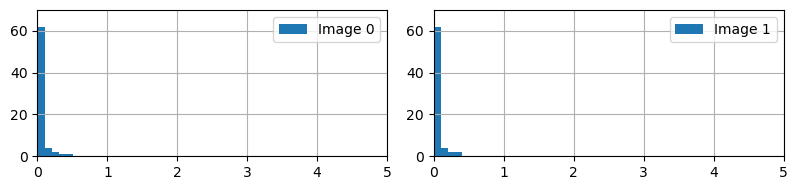

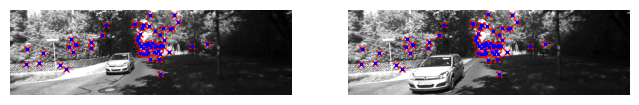

In [8]:
vio.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vio.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

Get post-optimization solution

In [9]:
T_inB0_ofW = np.block([[R_inW_ofB[first_frame_idx].as_matrix().T, - R_inW_ofB[first_frame_idx].as_matrix().T @ p_inW_ofB[first_frame_idx][:,np.newaxis]], 
                      [np.zeros(3), 1]])
T_inC0_ofW = T_inC_ofB @ T_inB0_ofW

T_inB1_ofW = np.block([[R_inW_ofB[second_frame_idx].as_matrix().T, - R_inW_ofB[second_frame_idx].as_matrix().T @ p_inW_ofB[second_frame_idx][:,np.newaxis]], 
                      [np.zeros(3), 1]])
T_inC1_ofW = T_inC_ofB @ T_inB1_ofW

views, tracks, initial_values, results = vio.vio_nonlinear_optimize(views, tracks, acc_meas[first_frame_idx:second_frame_idx], gyr_meas[first_frame_idx:second_frame_idx], 
                                                                    cam0_K, T_inC_ofB, max_reprojection_err,
                                                                    v_inW_ofB[first_frame_idx], v_inW_ofB[second_frame_idx],
                                                                    T_inC0_ofW, T_inC1_ofW)

[2024-05-05 21:55:26.441] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 715757127.934/0.000/59671980.000, rel reduction: 0.91663
[2024-05-05 21:55:26.451] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 59671978.039/0.000/148673.062, rel reduction: 0.99751
[2024-05-05 21:55:26.461] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 148673.055/0.000/69.856, rel reduction: 0.99953
[2024-05-05 21:55:26.470] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 69.856/0.000/41.712, rel reduction: 0.40288
[2024-05-05 21:55:26.480] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 41.712/0.000/40.281, rel reduction: 0.03430
[2024-05-05 21:55:26.489] [info] LM<sym::Optimize> [iter    5] lambda: 1.000e-05, error prev/linear/new: 40.281/0.000/36.387, rel reduction: 0.09667
[2024-05-05 21:55:26.498] [info] LM<sym::Optimize> [iter    6] lambda: 1.000e-0

Evaluate change in position between frames

In [10]:
# Symforce
R_inW_ofC0_sf = results.optimized_values['T_inC0_ofW'].R.to_rotation_matrix().T
p_inW_ofC0_sf = - R_inW_ofC0_sf @ results.optimized_values['T_inC0_ofW'].t

R_inW_ofB0_sf = R_inW_ofC0_sf @ R_inC_ofB
p_inW_ofB0_sf = R_inW_ofC0_sf @ p_inC_ofB + p_inW_ofC0_sf

R_inW_ofC1_sf = results.optimized_values['T_inC1_ofW'].R.to_rotation_matrix().T
p_inW_ofC1_sf = - R_inW_ofC1_sf @ results.optimized_values['T_inC1_ofW'].t

R_inW_ofB1_sf = R_inW_ofC1_sf @ R_inC_ofB
p_inW_ofB1_sf = R_inW_ofC1_sf @ p_inC_ofB + p_inW_ofC1_sf

# ground truth
R_inW_ofB0_gt = R_inW_ofB[first_frame_idx].as_matrix()
p_inW_ofB0_gt = p_inW_ofB[first_frame_idx]
v_inW_ofB0_gt = v_inW_ofB[first_frame_idx]

R_inW_ofB1_gt = R_inW_ofB[second_frame_idx].as_matrix()
p_inW_ofB1_gt = p_inW_ofB[second_frame_idx]
v_inW_ofB1_gt = v_inW_ofB[second_frame_idx]


In [11]:
gravity = results.initial_values['gravity']
dt_01 = results.initial_values['dt_01']

R_inB1_ofB0_gt = R_inW_ofB1_gt.T @ R_inW_ofB0_gt
R_inB1_ofB0_im = results.initial_values['dR_01'].T

dR_err = R.from_matrix(R_inB1_ofB0_gt @ R_inB1_ofB0_im.T).as_euler('xyz', degrees=True)
print(f'dR_err: {dR_err} [deg] (xyz)')

dv_gt = R_inW_ofB0_gt.T @ (v_inW_ofB1_gt - v_inW_ofB0_gt - gravity * dt_01)
dv_im = results.initial_values['dv_01']
dv_err = dv_im - dv_gt

print(f'dv_err: {dv_err} [m/s] (rel err: {np.linalg.norm(dv_err)/np.linalg.norm(dv_gt)*100:.2f} [%])')

dp_gt = R_inW_ofB0_gt.T @ (p_inW_ofB1_gt - p_inW_ofB0_gt - v_inW_ofB0_gt * dt_01 - 0.5 * gravity * dt_01 ** 2)
dp_im = results.initial_values['dp_01']
dp_err = dp_im - dp_gt

print(f'dp_err: {dp_err} [m] (rel err: {np.linalg.norm(dp_err)/np.linalg.norm(dp_gt)*100:.2f} [%])')


dR_err: [ 0.01207768 -0.00866781  0.01253415] [deg] (xyz)
dv_err: [-0.00177926 -0.00919343  0.00503582] [m/s] (rel err: 0.22 [%])
dp_err: [-0.07765309  0.05192076  0.10947331] [m] (rel err: 12.85 [%])



REPROJECTION ERRORS
 Image  0 (   66 points) : (mean, std, max, min) = (  0.09,   0.08,   0.55,   0.00)
 Image (raw reprojection)  0 (   66 points) : (mean, std, max, min) = (  0.09,   0.08,   0.55,   0.00)
 Image  1 (   66 points) : (mean, std, max, min) = (  0.08,   0.08,   0.54,   0.00)
 Image (raw reprojection)  1 (   66 points) : (mean, std, max, min) = (  0.08,   0.08,   0.54,   0.00)


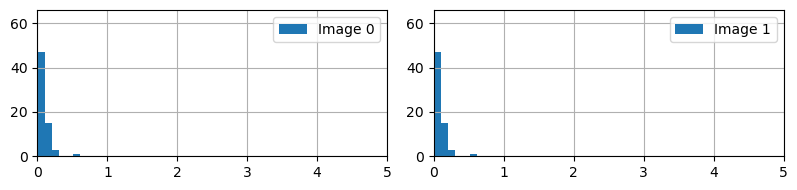

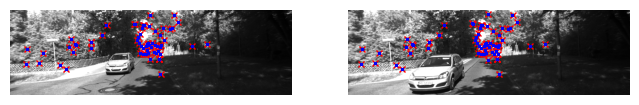

In [12]:
vio.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vio.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

### Compute APE - example
Note, because we only have 2 views we don't have sufficient data to actually do an alignment.

In [13]:
ape_results = pose_metrics.compute_ape(
    pose_metrics.create_tum_data_from_views(times=[visual_inertial_data[view['frame_id']]['time'] for view in views], views=views),
    pose_metrics.create_tum_data_from_groundtruth([visual_inertial_data[view['frame_id']] for view in views]),
    temporary_folder / Path('traj1.txt'),
    temporary_folder / Path('traj2.txt'),
    temporary_folder / Path('results.zip'),
    temporary_folder / Path('results/'),
    align='none', verbose=False, print_results=True,
)

KeyError: 'R_inB_ofA'

### Compute pose error (with my alignment) example
Basically, we do a coordinate transform so both trajectories start at 0 pose and identity rotation. Then we calculate the error for each time-step. In our case, we probably should just care about the final error elements (which specifies errors between first and last frame).

In [ ]:
pose_results = pose_metrics.compute_pose_error(
    pose_metrics.create_tum_data_from_views(times=[visual_inertial_data[view['frame_id']]['time'] for view in views], views=views),
    pose_metrics.create_tum_data_from_groundtruth([visual_inertial_data[view['frame_id']] for view in views]),
    align='posescale', print_results=True,
)